In [1]:
import adcc
import psi4
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 150  # Increase figure size a bit

In [2]:
# Run SCF in Psi4 (Forcing C1 point group symmetry)
mol = psi4.geometry("""
    units au
    symmetry c1
    
    O 0 0 0
    H 0 0 1.795239827225189
    H 1.693194615993441 0 -0.599043184453037
""")

psi4.core.be_quiet()
psi4.set_options({'basis': "cc-pvtz", 'e_convergence': 1e-7})
_, wfn = psi4.energy('SCF', return_wfn=True)

In [3]:
# Run ADC(1) on 7 singlets
n_singlets = 7
adc_1 = adcc.adc1(wfn, n_singlets=n_singlets)

Starting adc1  singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1    14      0.012896  212ms  [0.34323903 0.42335206 0.4264535  0.5040998  0.57560308 0.67036022
 0.68360101]
  2    28     0.0008338  150ms  [0.33610913 0.40199788 0.41805457 0.48454625 0.56050006 0.6565749
 0.67449104]
  3    42    7.7277e-06  150ms  [0.33608621 0.40166482 0.41797366 0.48407431 0.56020298 0.6562479
 0.67445091]
  4    56    4.5345e-08  211ms  [0.33608619 0.40166407 0.41797314 0.48407197 0.56020069 0.65624425
 0.67445087]
=== Converged ===
    Number of matrix applies:    56
    Total solver time:           735.954ms


In [4]:
# Build guess for ADC(2) by appending a zero doubles part to each vector
adc2matrix = adcc.AdcMatrix("adc2", adc_1.ground_state)
def append_doubles_block(adc1_vector):
    symmetries = adcc.guess_symmetries(adc2matrix,
                                       spin_block_symmetrisation="symmetric")
    return adcc.AmplitudeVector(adc1_vector["s"], adcc.Tensor(symmetries[1]))
guesses_1 = [append_doubles_block(exv) for exv in adc_1.excitation_vectors]

In [5]:
# Run ADC(2), ADC(2x) and ADC(3)
adc_2 =  adcc.adc2(adc2matrix, n_singlets=n_singlets, guesses=guesses_1)
adc_x = adcc.adc2x(adc_2.ground_state, n_singlets=n_singlets,
                     guesses=adc_2.excitation_vectors)
adc_3 =  adcc.adc3(adc_x.ground_state, n_singlets=n_singlets,
                     guesses=adc_x.excitation_vectors);

Starting adc2  singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     7       0.39576   2.5s  [0.4200399  0.4900751  0.5003575  0.57070234 0.64449847 0.7404646
 0.756921  ]
  2    14       0.34208  415ms  [0.29739422 0.36787642 0.45219552 0.49226151 0.55965312 0.63313253
 0.70433221]
  3    21      0.012265  423ms  [0.29463028 0.36748651 0.37789215 0.45003903 0.54687057 0.63206273
 0.64399173]
  4    28     0.0039621  520ms  [0.29454864 0.36746351 0.37549662 0.44985803 0.54561193 0.6319778
 0.63876247]
  5    35    0.00016335  587ms  [0.29454005 0.36746286 0.37528533 0.44984306 0.54553501 0.63197488
 0.63767778]
  6    42    1.8521e-05  599ms  [0.29453944 0.36746284 0.37527516 0.44984231 0.54552965 0.63197473
 0.63761533]
=== Restart ===
  7    14    1.3684e-06  651ms  [0.2945394  0.36746284 0.37527475 0.44984227 0.54552907 0.63197471
 0.63760987]
  8    21    3.1099e-07  472ms  [0.2945394  0.36746284 0.37527471 0.44984227 0.54552895 0.63197471
 0.63760881]
===

In [6]:
adc_3  # Display result summary

+--------------------------------------------------------------+
| adc3 (adc2)                             singlet ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0     0.3043778      8.282541   0.0378    0.9428   0.05719  |
|  1     0.3768004      10.25326   0.0000    0.9449    0.0551  |
|  2     0.3866938      10.52247   0.1000    0.9418   0.05822  |
|  3     0.4602102      12.52296   0.0570    0.9438   0.05623  |
|  4       0.54928      14.94667   0.2534    0.9526   0.04741  |
|  5      0.634464      17.26464   0.0000     0.938   0.06197  |
|  6     0.6439058      17.52157   0.0776    0.9497   0.05033  |
+--------------------------------------------------------------+


In [7]:
# Display amplitudes > 0.04
print(adc_3.describe_amplitudes(tolerance=0.04))

+-------------------------------------------------------+
| State   0 ,     0.3043778 au,      8.282541 eV        |
+-------------------------------------------------------+
| HOMO            -> LUMO             a ->a      -0.675 |
| HOMO            -> LUMO +3          a ->a     +0.0942 |
| HOMO            -> LUMO +4          a ->a     -0.0674 |

+-------------------------------------------------------+
| State   1 ,     0.3768004 au,      10.25326 eV        |
+-------------------------------------------------------+
| HOMO            -> LUMO +1          a ->a      +0.663 |
| HOMO            -> LUMO +2          a ->a       +0.14 |
| HOMO            -> LUMO +6          a ->a      -0.112 |

+-------------------------------------------------------+
| State   2 ,     0.3866938 au,      10.52247 eV        |
+-------------------------------------------------------+
| HOMO -1         -> LUMO             a ->a      +0.675 |
| HOMO -1         -> LUMO +3          a ->a     -0.0905 |

+----------

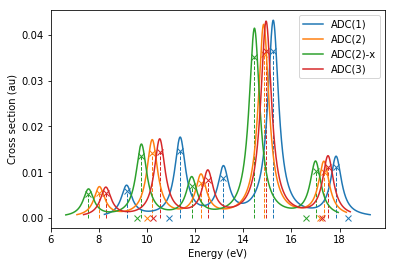

In [8]:
adc_1.plot_spectrum(label="ADC(1)")
adc_2.plot_spectrum(label="ADC(2)")
adc_x.plot_spectrum(label="ADC(2)-x")
adc_3.plot_spectrum(label="ADC(3)")
plt.legend()

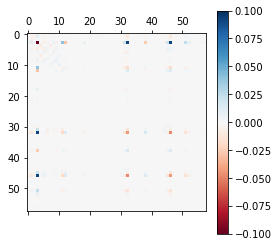

In [9]:
# Plot difference of ADC(2) and ADC(3) state densities of state with highest oscillator strength
imax = np.argmax(adc_3.oscillator_strengths)
dm_3_ao = adc_3.state_diffdms[imax].to_ao_basis()
dm_2_ao = adc_2.state_diffdms[imax].to_ao_basis()

dm_diff = (dm_3_ao[0] + dm_3_ao[1] - dm_2_ao[0] - dm_2_ao[1]).to_ndarray()
img = plt.matshow(dm_diff, cmap=matplotlib.cm.RdBu, vmax=0.1, vmin=-0.1)
plt.colorbar(img)